# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [Models](#Models)
* [Test harness](#Test-harness)
* [Metaclassifier](#Metaclassifier)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

In this notebook, the MLPClassifier from sklearn is cross validated with untuned hyperparameters.

5-fold train-test splits with scaling, dimensionality reduction, and resampling have already been preprocessed on the full dataset. The results are visualized and discussed.

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from os.path import exists
from tqdm.notebook import tqdm

# typing
from typing import Dict, List, Union

# faster pandas apply
import swifter

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score

# classifiers
from sklearn.neural_network import MLPClassifier

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

warnings.filterwarnings("ignore")
del warnings

time: 5.27 s


In [4]:
# Location of cross validation .feather files
FRILL_FEATHERS_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 132 ms


# Setup

In this section, we define some structures to keep track of models and scores.

The next cell defines a Python dictionary to record the results of cross validation such that the results may be easily cast to a `pandas` dataframe.

In [5]:
METRICS = (
    "balanced_accuracy",
    "f1",
    "geometric_mean",
    "roc_auc",
    "fit_time",
    "predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {key: [] for key in {"model_name", "case", *METRICS}}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    case: str,
    model_name: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's scores and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


ALL_CASES = {"negative", "neutral", "ternary", "ternary_negneu"}

_ = gc_collect()

time: 150 ms


In [6]:
predictions_ = {key: [] for key in {"model", "case", "fold", "y_pred"}}

Prediction = namedtuple("Prediction", predictions_.keys())


def store_prediction(where: Dict[str, List], prediction: Prediction) -> None:
    "Records the y_pred of a classifier on a fold"
    for k, v in prediction._asdict().items():
        where[k].append(v)


_ = gc_collect()

time: 122 ms


# Models

This notebook focuses on the MLPClassifier from sklearn. Other models were evaluated in other notebooks.

In [7]:
MODELS = {
    "MLP": lambda: MLPClassifier(random_state=SEED),
}

_ = gc_collect()

time: 118 ms


# Test harness

This section defines functions for evaluating models.

In [8]:
def prep_y_pred(label: Union[int, bool], case: str) -> List:
    """Prepares labels for AUROC scoring"""
    if "ternary" in case:
        _ = [0, 0, 0]
        _[int(label)] = 1
        return np.asarray(_, dtype=np.int8)
    else:
        return np.int8(label)


def evaluate_model(
    model_base: str, case: str, track_fold_time: bool = True
) -> AvgScores:
    """Evaluate a model with cross validation on prepared folds."""

    fit_times, predict_times, balanced_accuracy, f1, geometric_mean, roc_auc = (
        [],
        [],
        [],
        [],
        [],
        [],
    )
    fold_num = 0
    while True:
        if track_fold_time:
            fold_begin = time()

        # helper function
        read_feather_cv = lambda _set: pd.read_feather(
            f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/{_set}{'' if _set == 'X_test' else f'_{case[:3]}'}.feather"
        )

        # load training data
        try:
            X_train, y_train = read_feather_cv("X_train"), np.squeeze(
                read_feather_cv("y_train").values
            )
        except FileNotFoundError:
            break

        # initialize model
        model = MODELS[model_base]()

        # fit
        begin = time()
        model.fit(X_train, y_train)
        end = time()
        del X_train
        del y_train
        _ = gc_collect()
        fit_times.append(end - begin)
        print(f"fitted in {end - begin:.2f} s")

        # load test data
        X_test = read_feather_cv("X_test")

        # predict
        begin = time()
        predicted = model.predict(X_test)
        end = time()
        del X_test
        del model
        _ = gc_collect()
        predict_times.append(end - begin)
        print(f"predicted in {end - begin:.2f} s")
        del end
        del begin
        _ = gc_collect()
        store_prediction(
            where=predictions_,
            prediction=Prediction(
                model=model_base,
                case=case,
                fold=fold_num,
                y_pred=predicted,
            ),
        )

        # score
        score_params = {
            "y_true": np.squeeze(read_feather_cv("y_test").values),
            "y_pred": predicted,
        }
        balanced_accuracy.append(balanced_accuracy_score(**score_params, adjusted=True))
        f1.append(f1_score(**score_params, average="weighted"))
        geometric_mean.append(geometric_mean_score(**score_params))
        roc_auc.append(
            roc_auc_score(
                y_true=score_params["y_true"].astype(np.int8),
                y_score=np.stack(
                    pd.Series(score_params["y_pred"]).swifter.apply(
                        prep_y_pred, case=case
                    )
                ),
                average="weighted",
                multi_class="ovo",
            )
        )
        del score_params
        del predicted
        _ = gc_collect()

        if track_fold_time:
            print(
                f"{model_base} fold {fold_num + 1} completed in {time() - fold_begin:.2f} s"
            )
            del fold_begin

        fold_num += 1
        _ = gc_collect()

    return AvgScores(
        *[
            np.mean(_)
            for _ in (
                balanced_accuracy,
                f1,
                geometric_mean,
                roc_auc,
                fit_times,
                predict_times,
            )
        ]
    )


_ = gc_collect()

time: 137 ms


The next few cells evaluate models.

In [9]:
case = "negative"
for model in MODELS:
    loop_begin = time()
    print(f"evaluating {model}...")
    store_result(
        where=results_,
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case),
    )
    print(f"stored {model} for {case} classification in {time() - loop_begin:.2f} s")
    del loop_begin
    _ = gc_collect()

evaluating MLP...
fitted in 485.18 s
predicted in 0.08 s
MLP fold 1 completed in 488.06 s
fitted in 492.62 s
predicted in 0.09 s
MLP fold 2 completed in 495.61 s
fitted in 435.28 s
predicted in 0.14 s
MLP fold 3 completed in 438.20 s
fitted in 317.90 s
predicted in 0.19 s
MLP fold 4 completed in 320.83 s
fitted in 495.44 s
predicted in 0.09 s
MLP fold 5 completed in 498.49 s
stored MLP for negative classification in 2241.74 s
time: 37min 21s


In [10]:
case = "neutral"
for model in MODELS:
    loop_begin = time()
    print(f"evaluating {model}...")
    store_result(
        where=results_,
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case),
    )
    print(f"stored {model} for {case} classification in {time() - loop_begin:.2f} s")
    del loop_begin
    _ = gc_collect()

evaluating MLP...
fitted in 574.98 s
predicted in 0.09 s
MLP fold 1 completed in 578.57 s
fitted in 713.96 s
predicted in 0.07 s
MLP fold 2 completed in 717.47 s
fitted in 571.79 s
predicted in 0.15 s
MLP fold 3 completed in 575.53 s
fitted in 345.02 s
predicted in 0.18 s
MLP fold 4 completed in 348.61 s
fitted in 765.67 s
predicted in 0.15 s
MLP fold 5 completed in 769.37 s
stored MLP for neutral classification in 2990.12 s
time: 49min 50s


In [11]:
case = "ternary"
for model in MODELS:
    loop_begin = time()
    print(f"evaluating {model}...")
    store_result(
        where=results_,
        case=case,
        model_name=model,
        avg_scores=evaluate_model(model, case),
    )
    print(f"stored {model} for {case} classification in {time() - loop_begin:.2f} s")
    del loop_begin
    _ = gc_collect()

evaluating MLP...
fitted in 854.39 s
predicted in 0.11 s


Pandas Apply: 100%|██████████| 13494/13494 [00:00<00:00, 207549.57it/s]


MLP fold 1 completed in 858.45 s
fitted in 954.16 s
predicted in 0.11 s


Pandas Apply: 100%|██████████| 11524/11524 [00:00<00:00, 199145.33it/s]


MLP fold 2 completed in 958.05 s
fitted in 612.59 s
predicted in 0.14 s


Pandas Apply: 100%|██████████| 19319/19319 [00:00<00:00, 247296.78it/s]


MLP fold 3 completed in 616.72 s
fitted in 739.84 s
predicted in 0.17 s


Pandas Apply: 100%|██████████| 25883/25883 [00:00<00:00, 186206.80it/s]


MLP fold 4 completed in 743.73 s
fitted in 698.74 s
predicted in 0.11 s


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 192210.79it/s]


MLP fold 5 completed in 703.19 s
stored MLP for ternary classification in 3880.75 s
time: 1h 4min 40s


Let's peek at the results.

In [12]:
results_df = pd.DataFrame(results_).reset_index(drop=True)
results_df

,fit_time,predict_time,roc_auc,model_name,case,geometric_mean,balanced_accuracy,f1
0,445.282108,0.119524,0.643261,MLP,negative,0.641426,0.286521,0.647433
1,594.282392,0.128057,0.700604,MLP,neutral,0.679673,0.401207,0.779356
2,771.942046,0.128561,0.644469,MLP,ternary,0.504363,0.292461,0.580602


time: 39 ms


# Metaclassifier

After the binary classifiers are evaluated, the metaclassifiers are evaluated based on the binary predictions. The metaclassifiers' fit and score times are estimated by summing the fit and score times of the base estimators.

In [13]:
# helper function
get_time = lambda case, model_name, metric: results_df.query(
    f"case == '{case}' & model_name == '{model_name}'"
)[metric].item()

pred_df = pd.DataFrame(predictions_).query(f"case != 'ternary'")
for neutral_model in MODELS.keys():
    for negative_model in MODELS.keys():
        balanced_accuracy, f1, geometric_mean, roc_auc = [], [], [], []
        model_combo = f"{neutral_model}+{negative_model}"
        fold_num = 0
        while True:
            if not exists(
                ytrue_path := f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/y_test_ter.feather"
            ):
                break
            # ensemble
            fold_df = pred_df.query(f"fold == {fold_num}").drop(columns="fold")
            neutral_condition = f"case == 'neutral' & model == '{neutral_model}'"
            negative_condition = f"case == 'negative' & model == '{negative_model}'"
            query_fold = lambda criteria: fold_df.query(criteria).y_pred.item()
            df = pd.DataFrame(
                {
                    "neutral_prediction": query_fold(neutral_condition),
                    "negative_prediction": query_fold(negative_condition),
                }
            )
            del fold_df
            del negative_condition
            del neutral_condition
            del query_fold
            _ = gc_collect()

            # "predict" 0: negative, 1: neutral, 2: positive
            df["hybrid_prediction"] = df.neutral_prediction.replace(True, 1)
            df.loc[df["hybrid_prediction"] == False, "hybrid_prediction"] = df.loc[
                df["hybrid_prediction"] == False, "negative_prediction"
            ].replace([True, False], [0, 2])
            y_pred = df.hybrid_prediction.astype(np.int8)
            del df
            _ = gc_collect()

            # record y_pred
            store_prediction(
                where=predictions_,
                prediction=Prediction(
                    model=model_combo,
                    case="ternary_negneu",
                    fold=fold_num,
                    y_pred=y_pred,
                ),
            )

            # score
            score_params = {
                "y_true": np.squeeze(pd.read_feather(ytrue_path).values),
                "y_pred": y_pred,
            }
            balanced_accuracy.append(balanced_accuracy_score(**score_params))
            f1.append(f1_score(**score_params, average="weighted"))
            geometric_mean.append(geometric_mean_score(**score_params))
            roc_auc.append(
                roc_auc_score(
                    y_true=score_params["y_true"].astype(np.int8),
                    y_score=np.stack(
                        pd.Series(score_params["y_pred"]).swifter.apply(
                            prep_y_pred, case=case
                        )
                    ),
                    average="weighted",
                    multi_class="ovo",
                )
            )
            del score_params
            del y_pred
            _ = gc_collect()
            fold_num += 1
        del fold_num

        # helper function
        sum_times = lambda time_metric: get_time(
            "neutral", neutral_model, time_metric
        ) + get_time("negative", negative_model, time_metric)

        store_result(
            where=results_,
            case="ternary_negneu",
            model_name=model_combo,
            avg_scores=AvgScores(
                np.mean(balanced_accuracy),
                np.mean(f1),
                np.mean(geometric_mean),
                np.mean(roc_auc),
                sum_times("fit_time"),
                sum_times("predict_time"),
            ),
        )

        print(f"stored hybrid ternary classification results for {model_combo}")

        del balanced_accuracy
        del f1
        del geometric_mean
        del model_combo
        _ = gc_collect()
del pred_df
_ = gc_collect()

Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 264531.17it/s]


stored hybrid ternary classification results for MLP+MLP
time: 3.12 s


In [14]:
# save predictions
predictions_df = pd.DataFrame(predictions_)[["model", "case", "fold", "y_pred"]]
predictions_df.case = predictions_df.case.astype("category")
predictions_df.fold = predictions_df.fold.astype(np.uint8)
predictions_df.y_pred = predictions_df.y_pred.swifter.apply(np.int8)
predictions_df.to_feather(f"{DATA_OUT_FOLDER}/untuned_MLP_predictions_CV5.feather")
del predictions_df
_ = gc_collect()

Pandas Apply: 100%|██████████| 20/20 [00:00<00:00, 19963.37it/s]

time: 174 ms


Let's peek at the results.

In [15]:
results_df = (
    pd.DataFrame(results_)
    .sort_values(by=["model_name"], ascending=True)
    .sort_values(by=["fit_time", "predict_time"], ascending=True)
    .sort_values(
        by=["geometric_mean", "f1", "balanced_accuracy", "roc_auc"], ascending=False
    )
    .sort_values(by=["case"], ascending=True)
    .reset_index(drop=True)
)[
    [  # selection order
        "model_name",
        "case",
        "geometric_mean",
        "f1",
        "balanced_accuracy",
        "roc_auc",
        "fit_time",
        "predict_time",
    ]
]
results_df.loc[:, "case"] = results_df.loc[:, "case"].astype("category")
results_df

,model_name,case,geometric_mean,f1,balanced_accuracy,roc_auc,fit_time,predict_time
0,MLP,negative,0.641426,0.647433,0.286521,0.643261,445.282108,0.119524
1,MLP,neutral,0.679673,0.779356,0.401207,0.700604,594.282392,0.128057
2,MLP,ternary,0.504363,0.580602,0.292461,0.644469,771.942046,0.128561
3,MLP+MLP,ternary_negneu,0.520552,0.572137,0.528247,0.647159,1039.564499,0.247582


time: 29 ms


# Results

In this section, we create several visualizations to display the results.

Note that the charts depicting fit and predict times do not account for the dimensionality reduction step.

In [16]:
METRIC_NAMES = {
    "balanced_accuracy": "Balanced Accuracy",
    "f1": "F1 Score",
    "geometric_mean": "Geometric Mean",
    "roc_auc": "Area Under ROC Curve",
    "fit_time": "Fit Time",
    "predict_time": "Predict Time",
}

_ = gc_collect()

time: 119 ms


In [17]:
def plot_binary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    if time_metric:
        # When plotting fit/predict times, the dummy classifier is omitted since it is always the fastest.
        results_df = results_df.loc[~results_df.model_name.str.contains("Dummy")]

    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="case",
        data=results_df,
        hue_order=["neutral", "negative"],
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    g.set_axis_labels(x_var="", y_var="")
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 0.85),
        ncol=2,
        title=None,
    )

    if not time_metric:
        plt.ylim(0, 1)
    plt.setp(plt.gca().patches, linewidth=0)

    plt.suptitle(
        f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 115 ms


  0%|          | 0/6 [00:00<?, ?it/s]

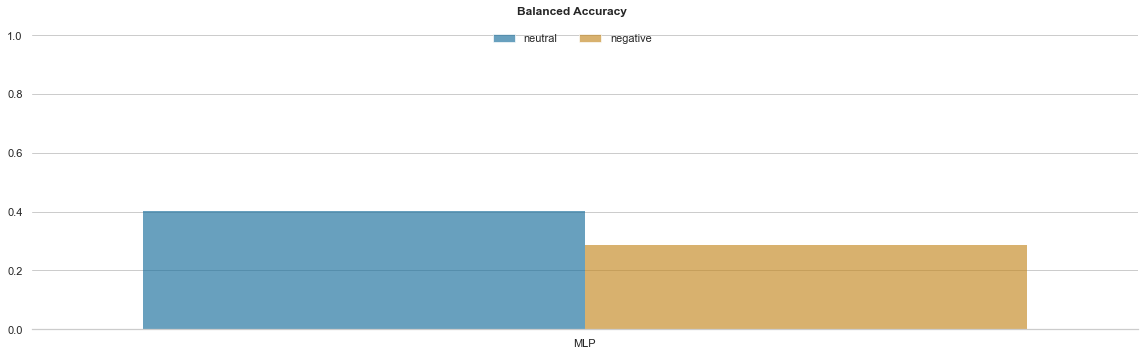

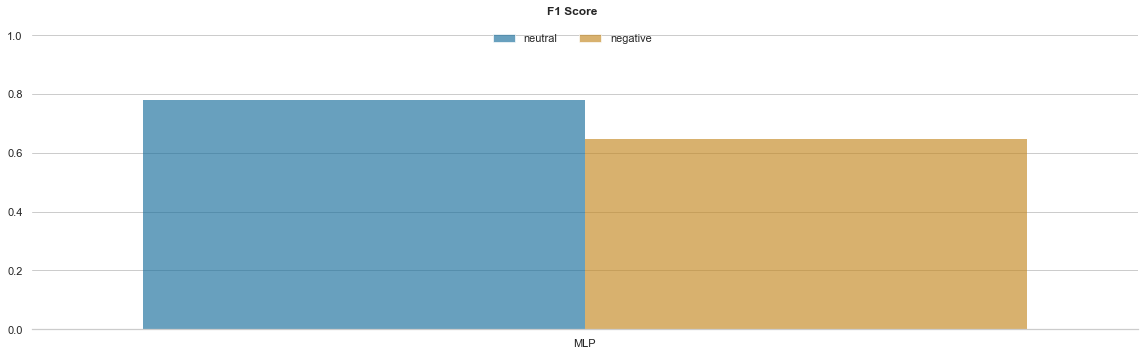

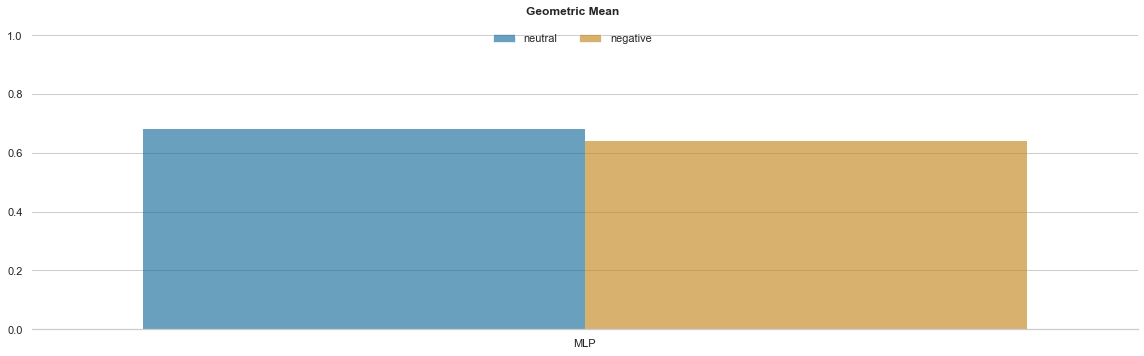

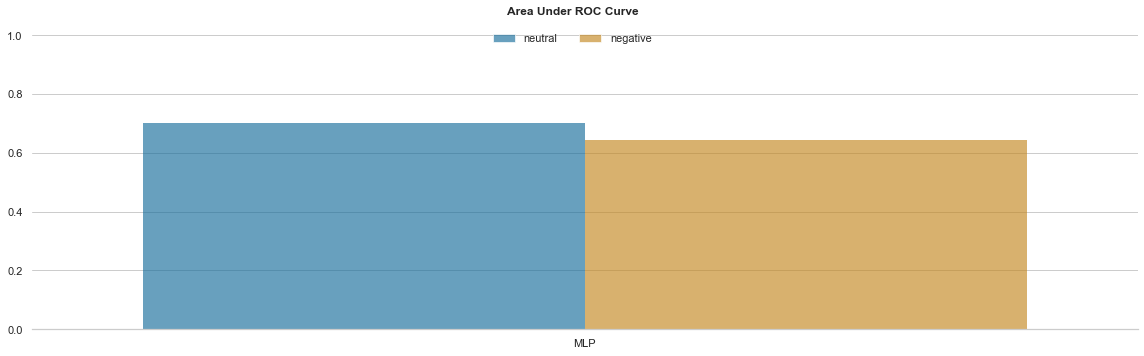

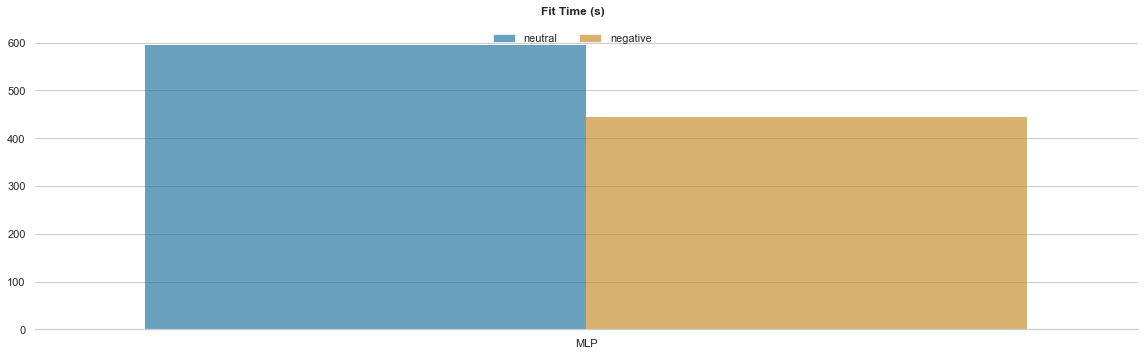

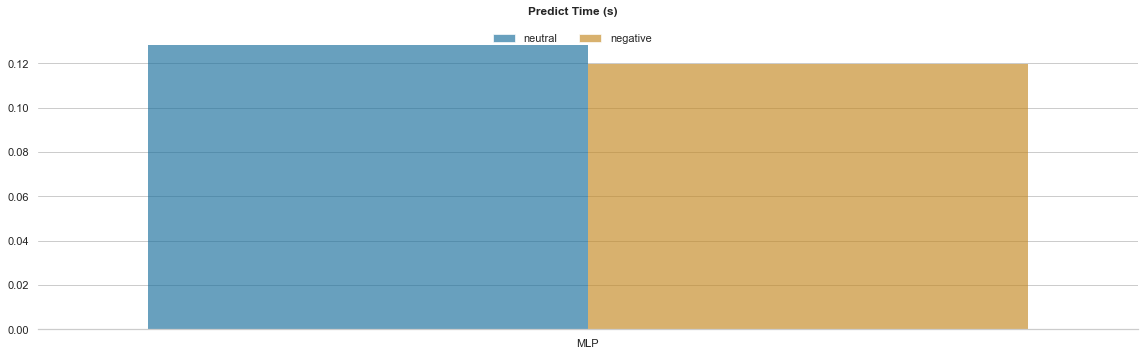

time: 1.97 s


In [18]:
for metric in tqdm(METRICS):
    plot_binary_metric(metric, results_df.loc[~results_df.case.str.contains("ternary")])

In [19]:
def plot_ternary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by ternary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)

    if time_metric:
        # When plotting fit/predict times, the pure dummy classifiers are omitted since it is always the fastest.
        results_df = results_df.loc[
            ~results_df.model_name.isin(("Dummy", "Dummy+Dummy"))
        ]

    g = sns.catplot(
        x=metric,
        y="model_name",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(10)
    g.fig.set_figheight(15)
    g.despine(**dict.fromkeys(("bottom", "left", "top", "right"), True))

    ax = plt.gca()
    ax.tick_params(axis="x", labelbottom=True, labeltop=True)
    plt.setp(ax.patches, linewidth=0)

    if not time_metric:
        plt.xlim(0, 1)
    plt.xlabel("")
    plt.ylabel("")

    plt.suptitle(
        f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", y=1, fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 124 ms


  0%|          | 0/6 [00:00<?, ?it/s]

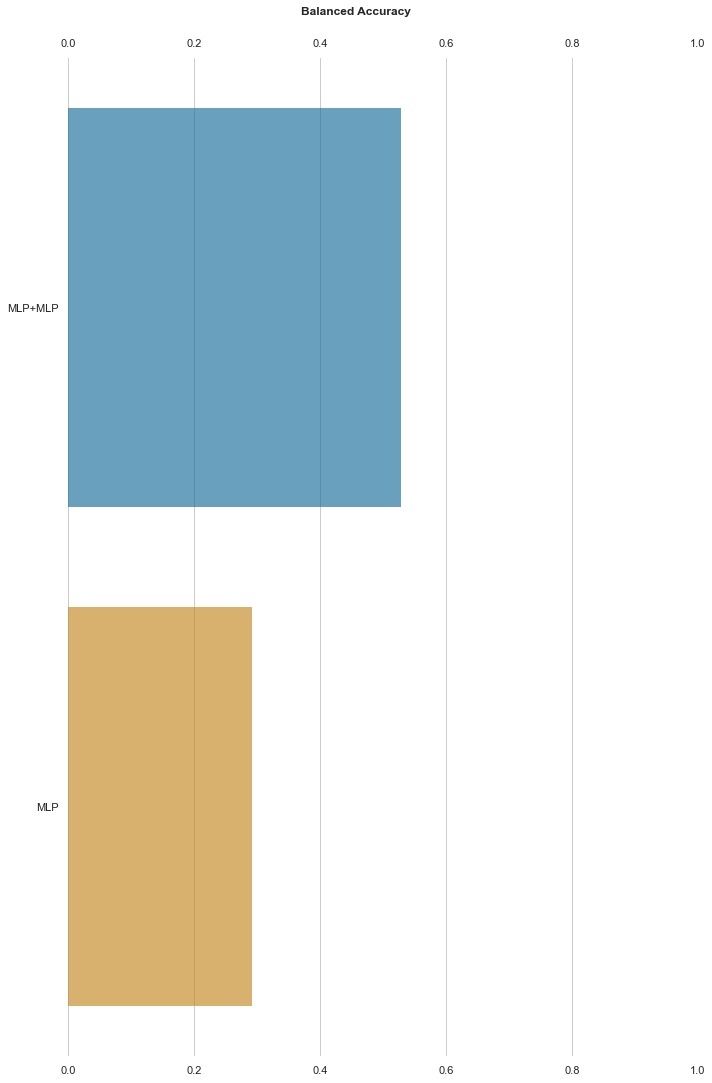

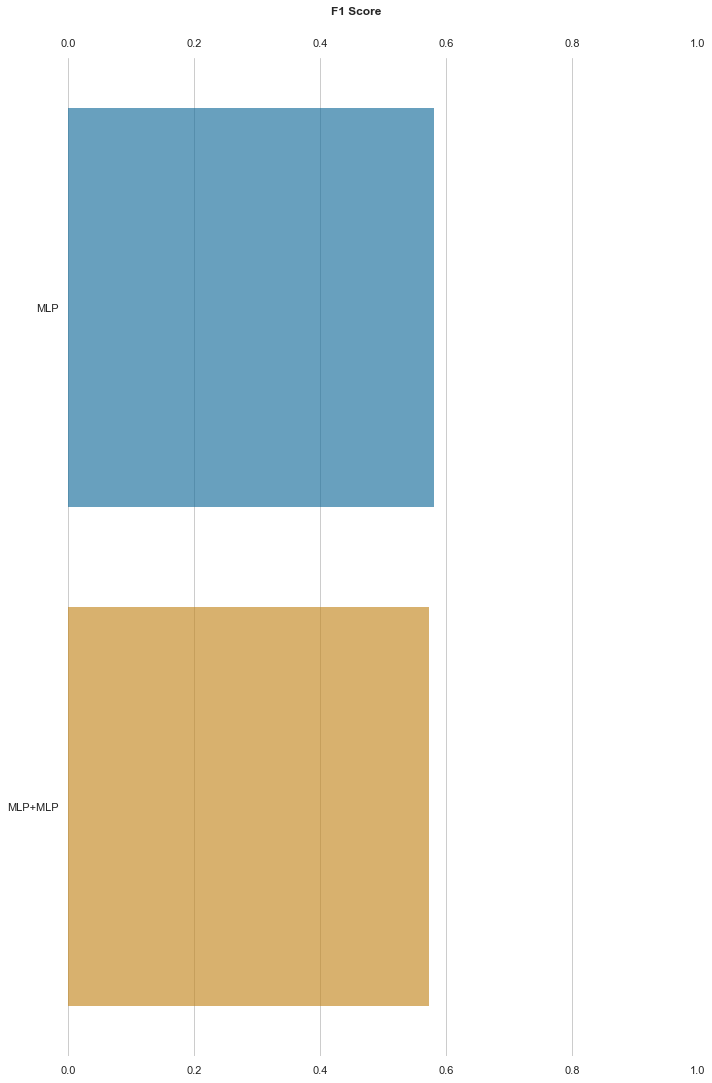

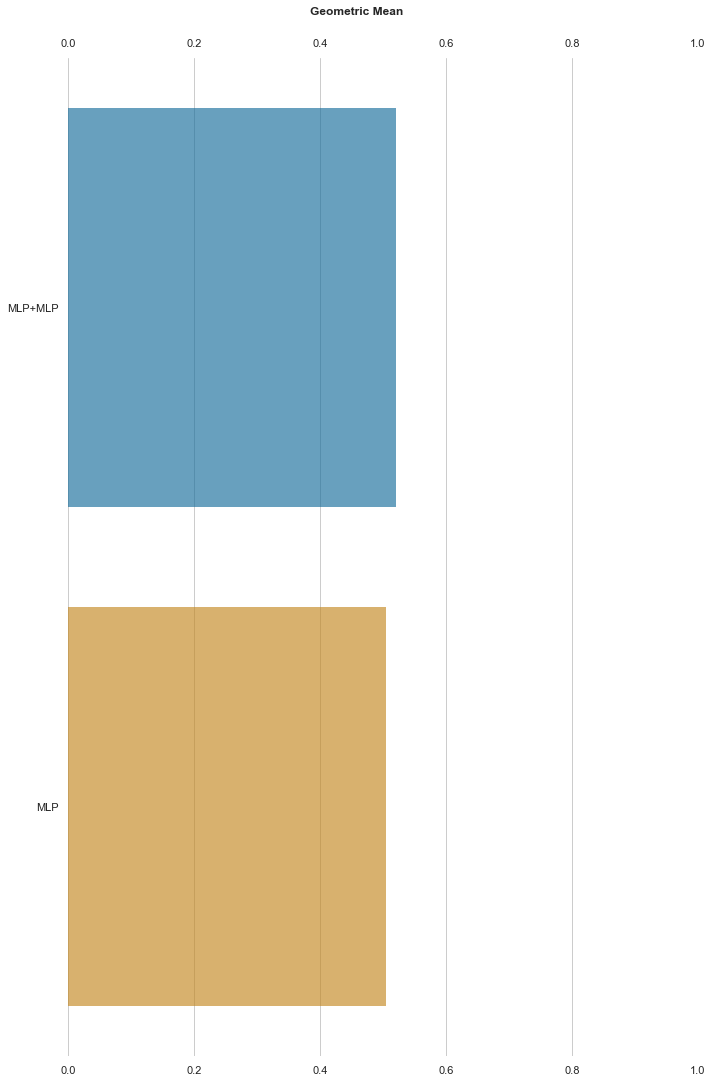

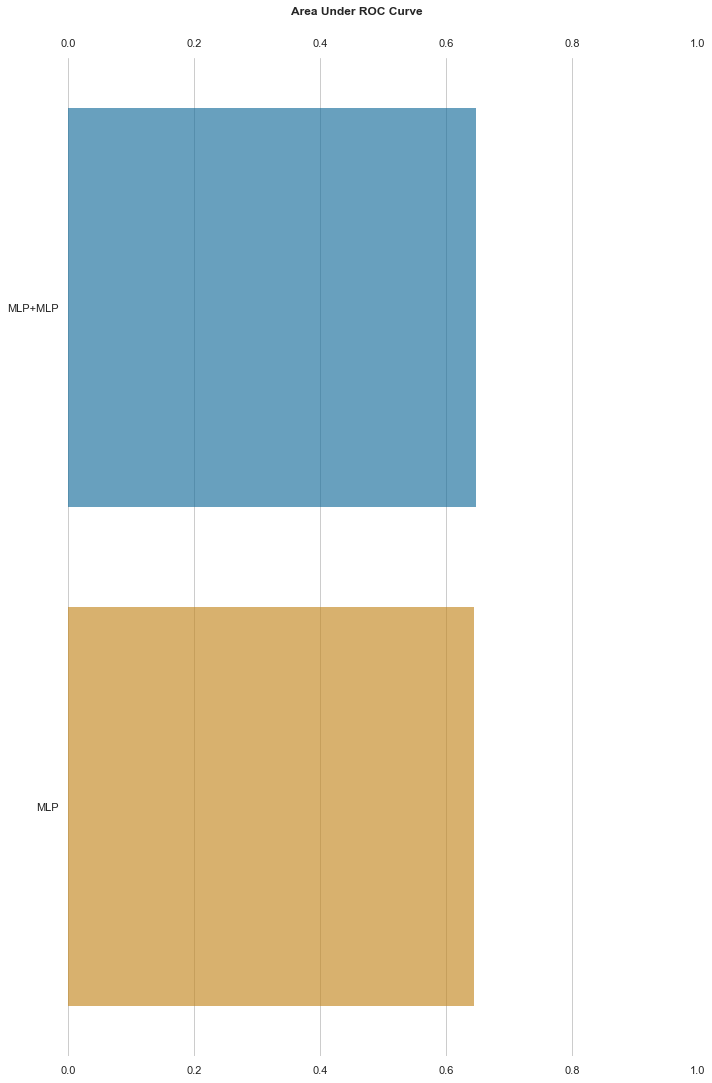

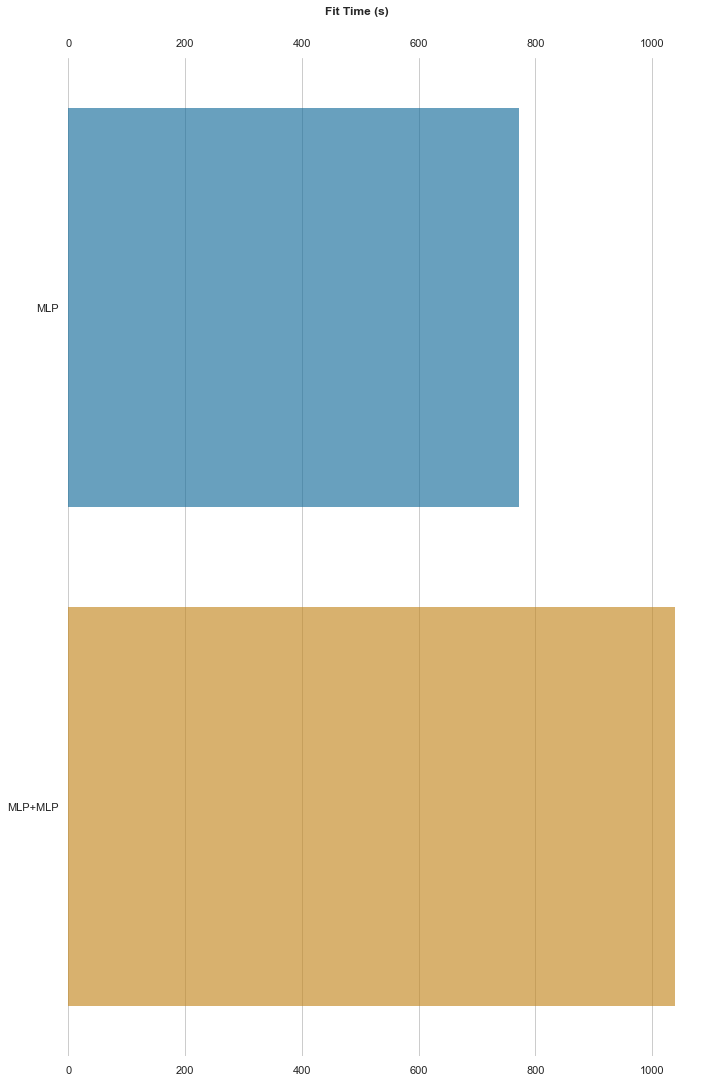

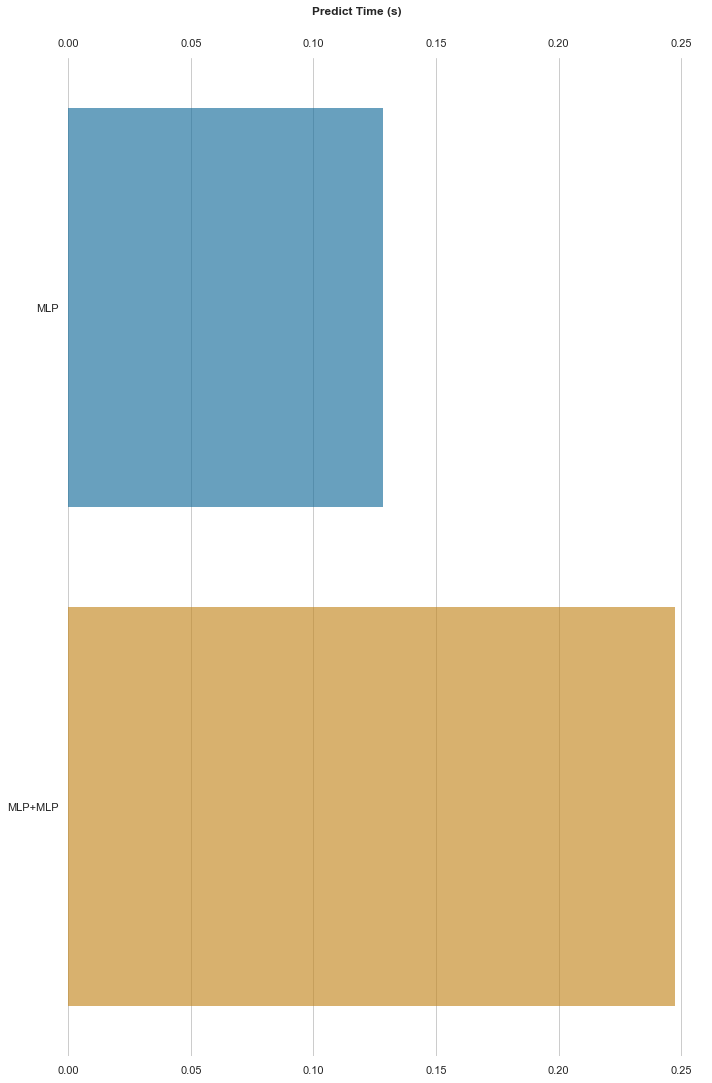

time: 1.92 s


In [20]:
for metric in tqdm(METRICS):
    plot_ternary_metric(metric, results_df.loc[results_df.case.str.contains("ternary")])

In [21]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/untuned_MLP_results_CV5.csv")

time: 11 ms


# Discussion

The plots are uninformative since there is only one model, but compared to other untuned classifiers cross-validated on the same splits, the MLPClassifier generally performed poorer with some exceptions.

Considering only single-stage models, the MLP was second last by geometric mean to SGD in binary negative and to SVC in ternary classification. By F1 score, it was second best to SVC in binary neutral and ternary classification. Otherwise, the MLP was the least performant amongst the single-stage models.

We have seen in previous notebooks that MLP performance suffers after the feature scaling, resampling, and dimensionality reduction of the splits herein. In examining a deep net approach further, these factors should be reconsidered.

It was interesting to see that the two-stage classifier outperformed the single-tier MLP by AUROC, G-mean and balanced accuracy especially in ternary classification; the margin is thin by F1 score. The two-tier MLP reports the highest observed adjusted balanced accuracy on these splits so far: about 52.8%.

In [22]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 9138.482224941254 s
time: 118 ms


[^top](#Contents)